# Using custom function of project
Import custom function and libraries

In [2]:
from libs.TrashbinDataset import TrashbinDataset
from libs.TDContainer import TDContainer
from libs.PretrainedModels import PretrainedModelsCreator, AlexNet_cc, SqueezeNet_cc, InceptionV3_cc
from libs.utils import get_model_name, import_dataset

from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import copy
from torch import nn

Define client function that allow to instantiate a Product using the Creator.

In [3]:
def init_model(creator: PretrainedModelsCreator, model_name: str, num_classes: int = 3, feature_extract: bool=True, use_pretrained: bool = True):
    print('Initializing: %s' % (model_name))
    creator.init_model(num_classes=num_classes, model_name=model_name, feature_extract=feature_extract, use_pretrained=use_pretrained)
    # creator.get_info()
    return creator

# Initialize dataset

In [4]:
dst_v0 = import_dataset('dataset', 
    train_transform=transforms.Compose([
        transforms.Resize(256),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # default dev and std for pretrained models
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), # crop centrale
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN), # NOTA: già su dataset_v2 è stato settato sul train
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # default dev and std for pretrained models
    ])
)

dst_v0.create_data_loader(batch_size=64, num_workers=2, drop_last=True)

### Visualize DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


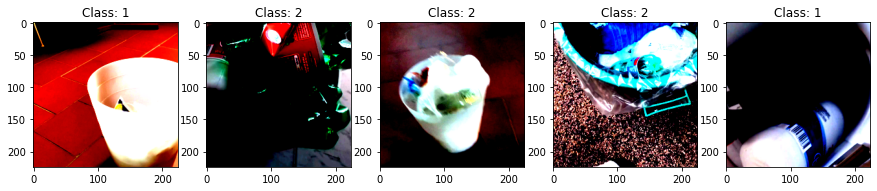

In [4]:
train_dataloader = dst_v0.training_loader

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]

    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    train_features, train_labels = next(iter(train_dataloader))
plt.show()

# Default values for trainings

In [5]:
num_epochs = 5
lr = 0.001
momentum = 0.99
criterion = nn.CrossEntropyLoss()

# li setto per evitare di scordarli ma non sono necessari
train_from_epoch = 0
save_each_iter = 1
resume_global_step_from = 0

Testo che i modelli funzionino correttamente e faccio un esempio su SqueezeNet per dimostrare che la procedura di fine tuning è migliore rispetto ad alleare da zero il modello

# SqueezeNet

In [6]:
squeezeNet_v0 = init_model(creator=SqueezeNet_cc(), model_name=get_model_name(model_name='SqueezeNet_v0', lr='0.001'), feature_extract=True, use_pretrained=True)
trained_model, history = squeezeNet_v0.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)

Initializing: SqueezeNet_v0__lr=0.001
Feature extract is setted to:  True
	 classifier.1.weight
	 classifier.1.bias
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 0/4
----------
train Loss: 0.4803 Acc: 0.7862
validation Loss: 0.1354 Acc: 0.9022
Epoch 1/4
----------
train Loss: 0.1940 Acc: 0.9232
validation Loss: 0.1441 Acc: 0.8948
Epoch 2/4
----------
train Loss: 0.1523 Acc: 0.9402
validation Loss: 0.0677 Acc: 0.9170
Epoch 3/4
----------
train Loss: 0.1384 Acc: 0.9467
validation Loss: 0.0734 Acc: 0.9141
Epoch 4/4
----------
train Loss: 0.1159 Acc: 0.9536
validation Loss: 0.0619 Acc: 0.9215
Training complete in 18m 38s
Best val Acc: 0.921481


In [7]:
squeezeNet_v0_scratch = init_model(creator=SqueezeNet_cc(), model_name=get_model_name(model_name='SqueezeNet_v0_scratch', lr='0.001'), feature_extract=False, use_pretrained=False)
trained_model, history = squeezeNet_v0_scratch.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)

Initializing: SqueezeNet_v0_scratch__lr=0.001
Feature extract is setted to:  False
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	

# AlexNet

In [ ]:
alexNet_v0 = init_model(creator=AlexNet_cc(), model_name=get_model_name(model_name='AlexNet_v0', lr='0.001'), feature_extract=True, use_pretrained=True)
trained_model, history = alexNet_v0.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)

# Inception

In [ ]:
inceptionv3_v0 = init_model(creator=InceptionV3_cc(), model_name=get_model_name(model_name='InceptionV3_v0', lr='0.001'), feature_extract=True, use_pretrained=True)
trained_model, history = inceptionv3_v0.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)